In [7]:
dat = pd.read_csv("results/distance2features.tab.gz", sep="\t", header=None, engine="pyarrow")

In [8]:
dat.columns = ["chrom", "start", "end", "maternal", "paternal", "avg", "prdm9", "prdm9_2", "islands", "tss"]

In [9]:
# List of features
features_to_bin = ["prdm9", "islands", "tss"]
binned_features = ["binned_{}".format(f) for f in features_to_bin]
rmaps = ["maternal", "paternal"]

# Length in base-pairs of the windows
wl = 1000

# Bin the distance measures
for feature in features_to_bin:
    dat[f"binned_{feature}"] = [round(x/wl)*wl for x in dat[feature]]

In [33]:
subd.groupby("binned_prdm9")[]

,chrom,start,end,maternal,paternal,avg,prdm9,prdm9_2,islands,tss,binned_prdm9,binned_islands,binned_tss,log10(cM/Mb)
0,chr1,1431800,1431900,0.025852,0.039046,0.032449,593,182,787,3850,1000,1000,4000,-1.488785
1,chr1,1431900,1432000,0.025852,0.039046,0.032449,493,82,887,3750,0,1000,4000,-1.488785
2,chr1,1432000,1432100,0.025852,0.039046,0.032449,393,0,987,3650,0,1000,4000,-1.488785
3,chr1,1432100,1432200,0.025852,0.039046,0.032449,293,0,1087,3550,0,1000,4000,-1.488785
4,chr1,1432200,1432300,0.025852,0.039046,0.032449,193,85,1187,3450,0,1000,3000,-1.488785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459425,chr1,247374300,247374400,0.053875,0.940092,0.496983,9001,9001,31614,44396,9000,32000,44000,-0.303658
2459426,chr1,247374400,247374500,0.000125,0.002229,0.001177,9101,9101,31514,44296,9000,32000,44000,-2.928855
2459427,chr1,247374500,247374600,0.000125,0.002229,0.001177,9201,9201,31414,44196,9000,31000,44000,-2.928855
2459428,chr1,247374600,247374700,0.000096,0.001697,0.000896,9301,9301,31314,44096,9000,31000,44000,-3.047208


<ipython-input-57-a31dbe775d92>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subd[y] = np.log10(dat.avg+minv)


30.976048431154116
46.34723143820191


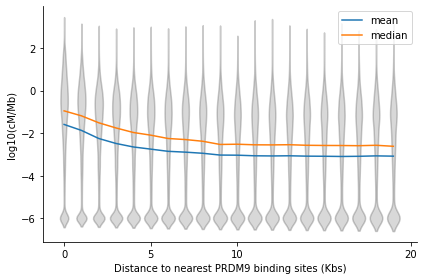

In [57]:
x = "binned_prdm9"
y = "log10(cM/Mb)"

subd = dat[(dat.chrom=="chr1") & (dat.binned_prdm9<20e3)]
minv = subd[subd["avg"]!=0].avg.min()
subd[y] = np.log10(dat.avg+minv)
#subd[y] = dat.avg

f,ax = plt.subplots(figsize=[6,4])

sns.violinplot(data=subd,
               color = "gray",
               x=x, y=y, 
               inner=None, 
               ax=ax)
means = subd.groupby(x)[y].mean().values
medians = subd.groupby(x)[y].median().values
print((10 ** means[0])/(10 ** means[-1]))
print((10 ** medians[0])/(10 ** medians[-1]))

ax.plot(means, label="mean")
ax.plot(medians, label="median")

xs = [0,5,10,20]
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.set_xlabel("Distance to nearest PRDM9 binding sites (Kbs)")

plt.setp(ax.collections, alpha=.3)
sns.despine()
ax.legend()

plt.tight_layout()
plt.savefig("pdfs/human_recombination_violins.pdf")

In [134]:
def boot(df, rounds, bottom, upper, func, norm):

    #CI by bootstrap
    boots = []
    
    for r in range(rounds):
        rdf = df.sample(n=len(df), replace=True)
        boots.append(func(rdf))
        
    return_df = pd.DataFrame([np.percentile(boots, bottom)/norm,
                              func(boots)/norm,
                              np.percentile(boots, upper)/norm
                             ]).transpose()
    return(return_df)
    
def rr_distance_to(d, norm_d, rmap, feature, name_feature, limit, norm, func, boot_n):
    
    #value to normalise
    n = func(norm_d[rmap])
    
    #recombination rate with distance slices
    result = d[d[feature]<limit].groupby(feature)[rmap].apply(lambda x: boot(x, boot_n, 2.5, 97.5, func, 1 if not norm else n))
    result = result.reset_index()
    result.columns = ["distance","feature","low_ci","midpoint","high_ci"]
    result.feature = name_feature
    result["rmap"] = rmap
    
    return result

In [141]:
far = 10e3
features_l = []
func = np.nanmean

for rmap in rmaps:
    for feature in features_to_bin:
        features_l.append(rr_distance_to(dat, 
                                         dat[dat[feature].between(15e3,20e3)], 
                                         rmap, 
                                         feature, 
                                         feature,
                                         20e3, 
                                         True, 
                                         func, 
                                         50))
        if feature=="prdm9":
            subdat = dat[(dat["islands"]>far) & (dat["tss"]>far)]
        if feature=="islands" or feature=="tss":
            subdat = dat[(dat["prdm9"]>far)]
        features_l.append(rr_distance_to(subdat, 
                                         subdat[subdat[feature].between(15e3,20e3)], 
                                         rmap, 
                                         feature, 
                                         f"cond_{feature}",
                                         20e3, 
                                         True, 
                                         func, 
                                         50))

features = pd.DataFrame(pd.concat(features_l))

In [142]:
def plot_ci(x, y1, y2, **kwargs):
    plt.fill_between(x, y1, y2, **kwargs)

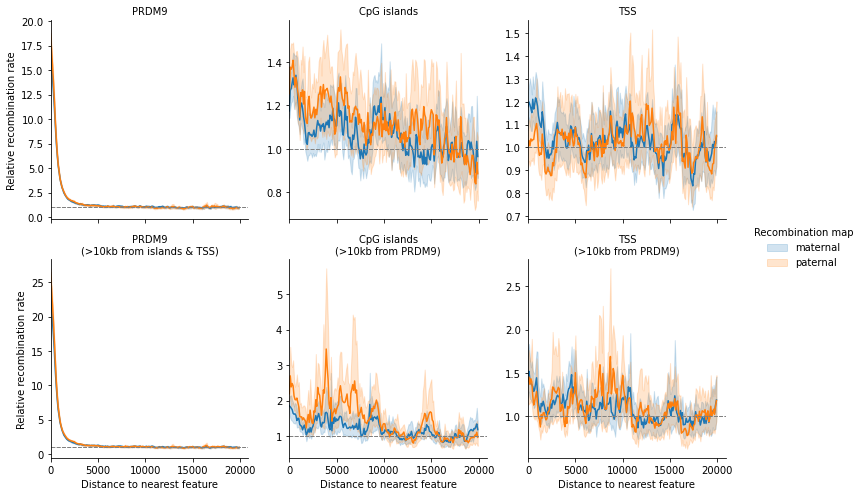

In [146]:
g = sns.FacetGrid(data=features, col="feature", height=3.5, col_wrap=3, aspect=1, hue="rmap", 
                  legend_out=True, sharey=False, 
                  col_order=["prdm9", "islands", "tss", 
                             "cond_prdm9", "cond_islands", "cond_tss"])

g.map(plt.plot, "distance", "midpoint")
g.map(plt.axhline, y=1, linestyle="dashed", color="gray", linewidth=1)
g.map(plot_ci, "distance", "low_ci", "high_ci", alpha=0.2)
g.set_axis_labels("Distance to nearest feature", "Relative recombination rate")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Recombination map")

titles = ["PRDM9", "CpG islands", "TSS", "PRDM9\n(>10kb from islands & TSS)", "CpG islands\n(>10kb from PRDM9)", "TSS\n(>10kb from PRDM9)"]
for i,(l,ax) in enumerate(g.axes_dict.items()):
    ax.set_title(titles[i], fontsize=10)

g.set(xlim=(0, None))
g.tight_layout()
g.savefig("pdfs/human_recombination_distance2features_mean_freeY.pdf")